In [1]:
import qiskit
import math
import numpy as np
np.random.seed(0)

### A. Construct functions to yield QFT and inverse-QFT circuits for an arbitrary number of qubits nq using (a) basic QISkit gates and (b) basic Cirq gates

Test the behavior of your quantum circuits by creating initial configurations of 8 and 12 qubits, which correspond to harmonic phase advances over all input states:

(i) 2, 4, 8 states per cycle

(ii) 6 states per cycle

(ii) apply only a Z-gate to qubit nq/2

Report and interpret the results from running QFT on these initial configurations and the results from running QFT and inverse-QFT.

### QFT Qiskit

In [2]:
def QFTqiskit(circuit=None, qubits=[], with_swaps=False, min_angle=0.):
    # Initialize variables for the circuit and the list of qubits to be used.
    circ = None
    qubit_list = []
    
    # Determine how to interpret the 'qubits' argument.
    # If it's an integer, treat it as the number of qubits.
    if isinstance(qubits, int):
        qubit_list = list(range(qubits))
    # If it's a numpy array, convert it to a list.
    elif isinstance(qubits, np.ndarray):
        qubit_list = qubits.tolist()
    # If it's a non-empty list or tuple, use it directly.
    elif isinstance(qubits, (list, tuple)) and len(qubits) > 0:
        qubit_list = qubits
    # If it's a QuantumRegister, create a new QuantumCircuit using it.
    elif isinstance(qubits, qiskit.circuit.quantumregister.QuantumRegister):
        circ = qiskit.QuantumCircuit(qubits)
        qubit_list = list(range(qubits.size))
    # If a circuit is provided (and qubits wasn't one of the above), copy the circuit.
    elif circuit is not None:
        circ = circuit.copy()
        qubit_list = list(range(circ.num_qubits))
    
    # Calculate the number of qubits from the qubit list.
    nq = len(qubit_list)
    if nq == 0:
        # If no valid qubits were provided, display an error and exit.
        print("Error: input must be 'circuit' or 'qubits'")
        return None
    
    # If no circuit was created or provided, instantiate a new QuantumCircuit with nq qubits.
    if circ is None:
        circ = QuantumCircuit(nq)
    
    # Loop over each qubit in reverse order to build the QFT circuit.
    for i in reversed(range(nq)):
        # Apply a Hadamard gate to the i-th qubit.
        circ.h(qubit_list[i])
        # For each qubit before i, apply a controlled phase (cp) gate.
        for j in reversed(range(i)):
            # Calculate the angle for the controlled phase gate.
            # Note: j-i is negative so math.pow(2, (j-i)) gives the correct fraction of π.
            mypow = math.pi * math.pow(2, (j - i))
            # Apply the cp gate only if the computed angle is above a specified minimum.
            if mypow > min_angle:
                circ.cp(mypow, qubit_list[j], qubit_list[i])
        # Add a barrier for visual clarity in the circuit.
        circ.barrier()
    
    # Optionally, add swap gates to reverse the order of qubits, which is common in QFT.
    if with_swaps:
        for i in range(nq // 2):
            circ.swap(qubit_list[i], qubit_list[nq - i - 1])
    
    # Return the resulting QuantumCircuit implementing the QFT.
    return circ

In [3]:
def invQFTqiskit(circuit=None, qubits=[], with_swaps=False, min_angle=0.):
    # Initialize the circuit variable and an empty list to hold qubit indices.
    circ = None
    qubit_list = []
    
    # Determine the type of input provided for 'qubits' and construct the qubit list accordingly.
    if isinstance(qubits, int):
        # If 'qubits' is an integer, create a list of qubit indices from 0 to qubits-1.
        qubit_list = list(range(qubits))
    elif isinstance(qubits, np.ndarray):
        # If 'qubits' is a NumPy array, convert it to a list.
        qubit_list = qubits.tolist()
    elif isinstance(qubits, (list, tuple)) and len(qubits) > 0:
        # If 'qubits' is a non-empty list or tuple, use it directly.
        qubit_list = qubits
    elif isinstance(qubits, qiskit.circuit.quantumregister.QuantumRegister):
        # If 'qubits' is a QuantumRegister, create a new QuantumCircuit with it and get the indices.
        circ = qiskit.QuantumCircuit(qubits)
        qubit_list = list(range(qubits.size))
    elif circuit is not None:
        # If a circuit is provided (and none of the above conditions are met), copy it
        # and extract the qubit indices from the circuit.
        circ = circuit.copy()
        qubit_list = list(range(circ.num_qubits))
    
    # Determine the number of qubits based on the qubit list.
    nq = len(qubit_list)
    if nq == 0:
        # If no valid qubit information is provided, print an error and exit.
        print("Error: input must be 'circuit' or 'qubits'")
        return None
    
    # If no circuit was created from the input, instantiate a new QuantumCircuit with nq qubits.
    if circ is None:
        circ = QuantumCircuit(nq)    
    
    # If the with_swaps flag is True, apply swap gates to reverse the order of qubits.
    if with_swaps:
        # Loop over the first half of the qubit list (in reverse order) to swap qubits symmetrically.
        for i in reversed(range(nq // 2)):
            circ.swap(qubit_list[i], qubit_list[nq - i - 1])
        # Add a barrier after the swap operations for clarity.
        circ.barrier()
    
    # Build the inverse Quantum Fourier Transform (QFT) circuit.
    for i in range(nq):
        # For each qubit, add controlled phase (cp) gates from all previous qubits.
        for j in range(i):
            # Calculate the phase angle (negative for the inverse QFT).
            mypow = -math.pi * math.pow(2, (j - i))
            # Only add the cp gate if the absolute phase is greater than the minimum threshold.
            if abs(mypow) > min_angle:
                circ.cp(mypow, qubit_list[j], qubit_list[i])
        # Apply a Hadamard gate to the current qubit.
        circ.h(qubit_list[i])
        # Insert a barrier to visually separate the operations for each qubit.
        circ.barrier()
    
    # Return the completed QuantumCircuit implementing the inverse QFT.
    return circ

#### (i) 2, 4, 8 states per cycle

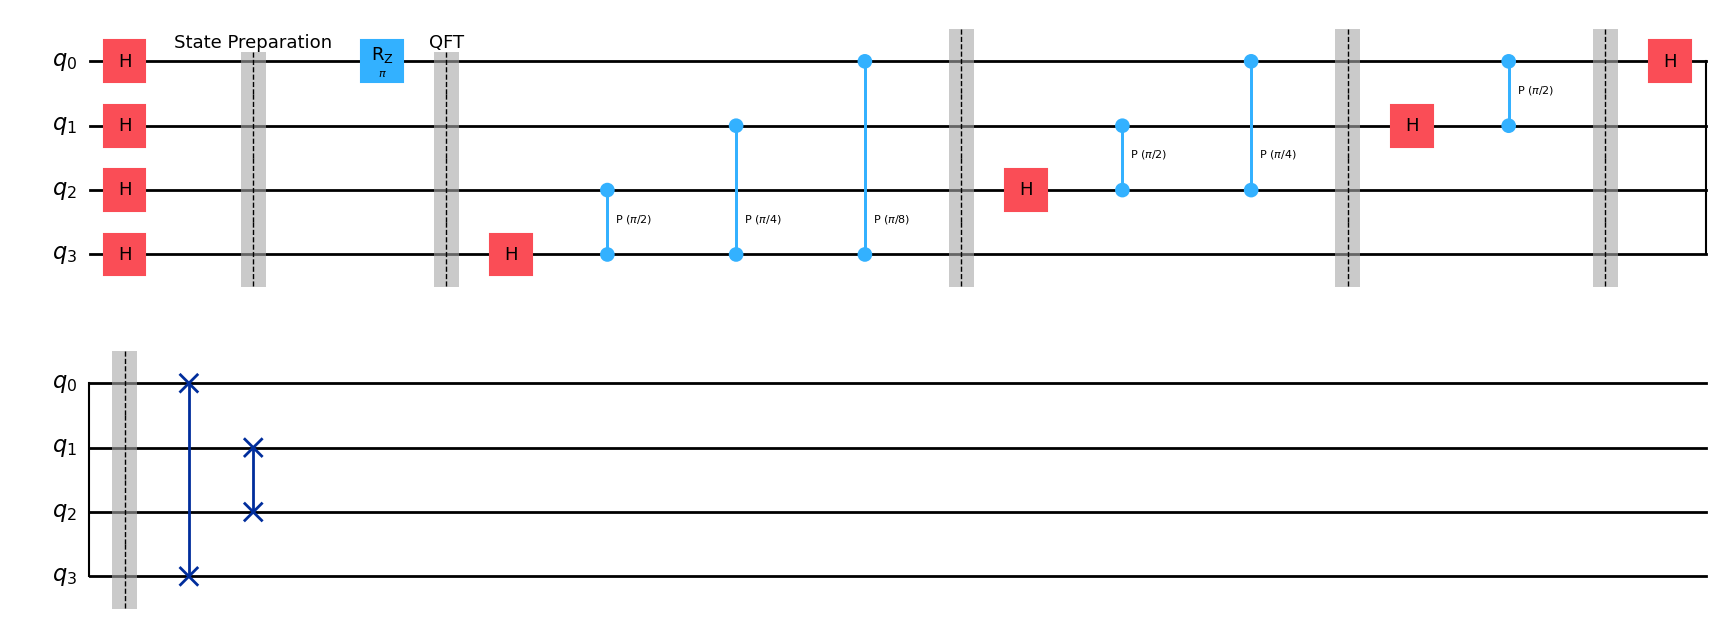

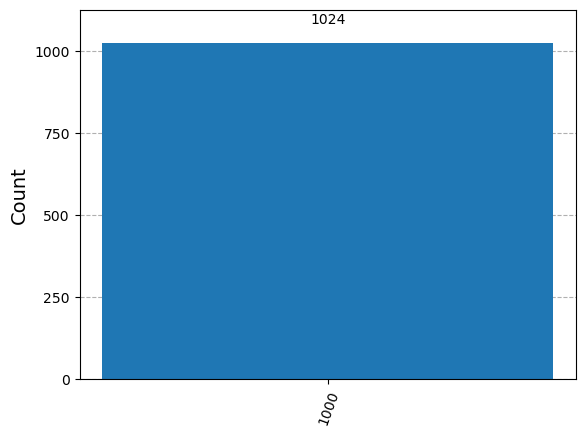

In [18]:
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

# Set up the 4 qubit register with harmonic oscillator basis states

nqubits = 4
qc_qft = QuantumCircuit(nqubits)
qc_qft.h(list(range(nqubits)))

qc_qft.barrier(label = "State Preparation")
qc_qft.rz(np.pi,0)

qc_qft.barrier(label = "QFT")
qc_qft = QFTqiskit(qc_qft, with_swaps=True)
display(qc_qft.draw('mpl', plot_barriers=True))
qc_qft.measure_all()
counts = Aer.get_backend('qasm_simulator').run(qc_qft).result().get_counts()
plot_histogram(counts)

#### (ii) 6 states per cycle

In [4]:
# qiskit

In [5]:
# cirq

#### (iii) apply only a Z-gate to qubit nq/2

### B : When measuring quantum systems in the computational basis, you only have access to the magnitudes of each state. In order to get a phase information, you may perform a QPE.

Estimate the (assumed unknown) angle $φ$ of a phase gate $P(φ, q_0)$ via a QPE to better than $3\%$. To test your code, start with angles $φ=π/2, π/4$ and $φ=π/3,π/6$; then choose an arbitrary angle between 0.2 and 0.9.

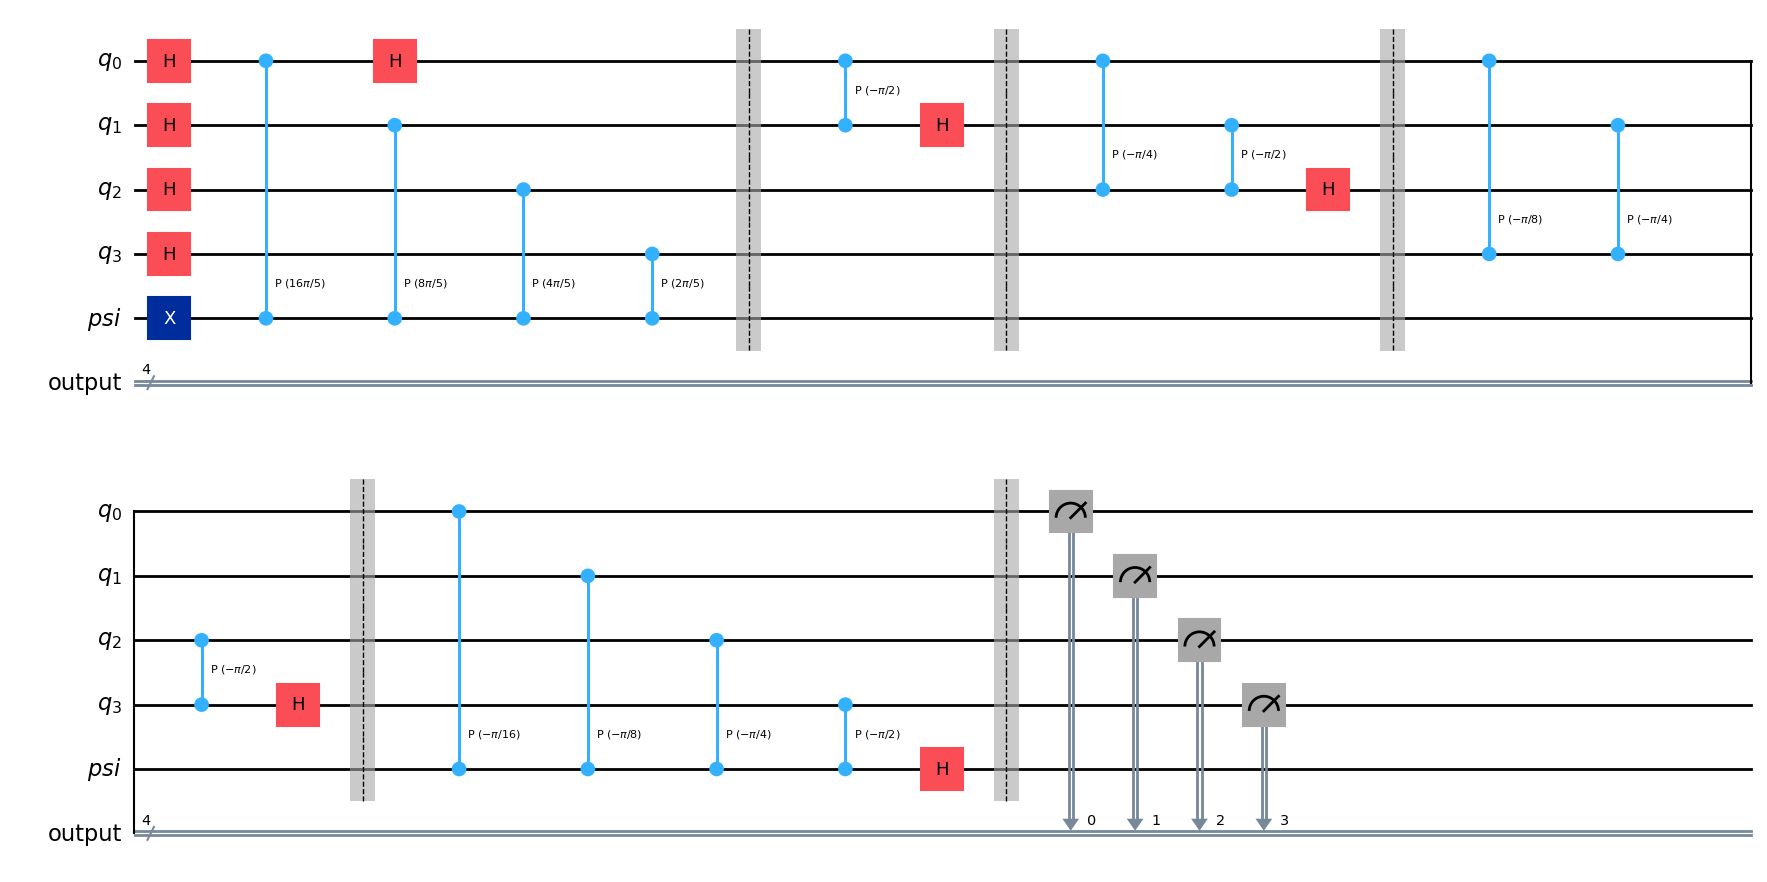

In [47]:
from qiskit_aer import Aer
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

def U(phi):
    U_circ = QuantumCircuit(1)
    U.PhaseGate(phi, label = 'U')
    return U_circ

# test angle
# phi = np.pi/2
phi = 2 * np.pi / 5

# Phase Estimation Test
# estimation qubits
n_estimator = 4

estimator = QuantumRegister(n_estimator,"q")
psi = QuantumRegister(1, "psi")
estimator_meaure = ClassicalRegister(n_estimator, 'output')
qc = QuantumCircuit(estimator, psi, estimator_meaure,name = 'QPE')

# Prepare the target qubit in the state |1>, which is an eigenstate of P(φ).
qc.x(psi)

# Apply Hadamard gates to the estimation (counting) register.
qc.h(estimator)

# Apply controlled-U operations.
# Here U = P(φ) and for the q-th counting qubit (starting from the most significant)
# we apply U^(2^(n_count-q-1)) controlled by that qubit.

for q in range(n_estimator):
    exponent = 2 ** (n_estimator - q - 1)
    # The controlled phase gate cp(angle, control, target) applies a phase e^(i*angle)
    # when the control qubit is |1>. Hence, we apply cp(exponent * phi, control, target).

    # Replace with controlled U gate
    qc.cp(exponent * phi, q, n_estimator) ##### instead I can create some sort of U gate that I do my control over

qc = invQFTqiskit(qc) # swaps don't seem to be working right...

# Measure the counting register.
qc.measure(range(n_estimator), range(n_estimator))

display(qc.draw('mpl', plot_barriers=True))

In [48]:
backend = Aer.get_backend('aer_simulator')
job = backend.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
# backend = Aer.get_backend('qasm_simulator')
# result = backend.run(qc.decompose, shots=1000).result()
# counts = result.get_counts()

# Get the outcome with the highest probability.
measured_str = max(counts, key=counts.get)
measured_val = int(measured_str, 2)

# The binary outcome corresponds to a fraction m / 2^n_count.
# Since the eigenphase (normalized) is φ/(2π), we recover φ by:
phi_est = measured_val / (2 ** n_estimator) * 2 * math.pi
# return qc, counts, phi_est

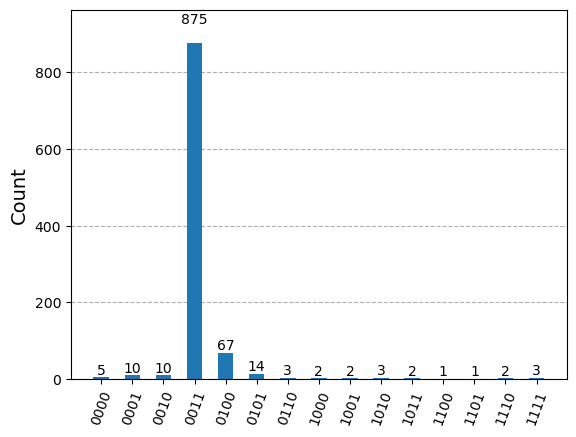

In [49]:
plot_histogram(counts)

### C: Solve the small system of linear equations using the HHL algorithm, given by:

$$
A = \begin{bmatrix}
a & b\\
b & a
\end{bmatrix}
,  \vec{b} = \begin{bmatrix}
cos\theta \\
sin\theta
\end{bmatrix}
$$

To test the code, start with values $a = 1; b = -\frac{1}{3}; \theta=0 $; then sweep the angle between $0$ and $\pi$.

### D (Extra Credit); Set up a circuit solving the SLE given under "Notes" to the HHL algorithm in QPE_HHL.ipynb

$$ A=\frac{1}{4} \begin{pmatrix} 15 & 9 & 5 & -3 \\ 9 & 15 & 3 & -5 \\
5 & 3 & 15 & -9 \\ -3 & -5 & -9 & 15 \end{pmatrix} \ , 
\quad \vec{b} =\frac{1}{2}\begin{pmatrix} 1 \\ 1 \\ 1 \\ 1 \end{pmatrix}$$